# Symposium


In [25]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
plt.style.use('seaborn') 
mpl.rcParams['font.family'] = 'serif'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import seaborn as sns
%matplotlib inline

In [26]:
mpl.__version__

'3.0.3'

In [27]:
from collections import Counter
import copy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)
import scipy as sci
import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as interp
import random as rnd
import debug_control as dbc
import datetime as dt
import json
import businessdate as bdte
import curve_constructor as cv
import curve_constructor_lorimier as cvl
import interest_rate_base as int_base
import interest_rate_dates as int_date
import interest_rate_capfloor_convenience as capconv
import interest_rate_instruments as int_rate
import interest_rate_discount as int_disc
import ir_discount_review as int_disc_rvw
from pyfi_error_viz import comp_plot


with open('./data/lorimier_20201121.json', 'r') as fp:
    options_lor = json.load(fp)
fp.close()

## Talk Outline
* __Current Situation__:
    - __GOAL__ of  this exercise is pricing of fixed income securities based on ones or more assets incorporating multiple financial derivatives
        directly and or indirectly.
    - LIBOR  / SWAP bootstrap 
        * LIBOR migration
        * ICE pricing of SWAPs
        * LIBOR includes credit risk (AA financial institution) 
    - __Option__ Use treasury prices to derive forward curve

* __Generate Discount (Forward Curve)__ (Treasury)
    - Bond Math Reminder
    - Curve Fitting Options
        * Bootstrapping
        * Splines
            * Smoothing Splines (Lorimier's method)
        * Parametric fits
        * PCA
* __Starting with Bond Prices__ -- example (data statistics)
    - Data Review
    - Classification
    - Exclusions
* __Estimation__
    - Yields
    - Zero Prices
    - Treasury Bonds & Notes Pricing
* __Next Steps__:
    - Better Bond Pricing Data
    - Estimation Additional Rates
    - Simulation
    - Analytic metrics
* __Closing Remarks__:
    - Why Does it matter?__
        - Embedded Options
        - Complex Structures
        - Common Duration metrics assume constant CF in face of changing interest rates
    
Notes Regarding the Bibliography__
    - Data & Analytics Providers 
        QuantLib (C++ & Python)
    - Open Source 
* __Bibliography__

# Generate Forward Curve
### Reminder (Bond Math)
A zero coupon bond $P(0, T)$ is an instrument that  pays 1.0 at Time $T$. The simple return $r(t, T)$ is
$$ P(t, T) = \frac{1}{1 + (T-t)r(t, T)}$$
For this exposition we will work in continuous time (the Yield-to-Maturity):
$$ P(t, T) = e^{-(T - t)y(t,T)} \quad \quad (R.1)$$
By varying maturities (T) in $(R.1)$ we obtain the term structure of zero-coupon (discount bonds) prevailing at time $t$. For small lending periods
$T_{1} -> T_{0}$ at $t < T_{0}$ we obtain instantaneous forward rate with maturity $T = T_{0}$:
$$ P(t, T) = e^{-\int^{T}_{t} f(u)du} \quad (R.2)$$
This implies that (in the continuous case) forward rates are related to yields by:
$$ y(t, T) = \frac{1}{(T - t)}\int^{T}_{t} f(t, u) du \quad \quad (R.3)$$
This said, any fixed income instrument is contract evaluated at times $t < T_{0} < T_{1} < \ldots <T_N = T$ resulting payments to at least one of participants. 
#### Coupon Bonds
A __fixed coupon bond__ is fixed income instrument paying constant coupon $C$ at times $t < T_0 < T_1 < \ldots <T_{N-1}$ and $Pr(incipal) + C$ at $T_N = T$. The price of a coupon bond $P_{c}(t, T)$ is 
$$ \sum_{i = T_0}^{T_{N-1}} P(t, T_i)*C + P(t, T_N)*(Pr + C) \quad (R.4.c) $$
and similarily for floating rate bond with variable coupons $C_i$ at times $t < T_0 < T_1 < \ldots <T_{N}$:
$$ \sum_{i = T_0}^{T_{N-1}} P(t, T_i)*C_i + P(t, T_N)*(Pr + C_N) \quad (R.4.f) $$

A quick deviation -- __clean versus dirty prices__:
Items $(R.4.c)$ and $(R.4.f)$ assumes the buyer it entitled to all of $C_0$, this is incorrect if settle date exceeds coupon accrual start. The buyer is entitled to coupon_date  - settle date of coupon; while, the seller is entitled to settle_date - accrual start. The resolution is for buyer to receive $C_0$ in full, but __pay__ the seller accrued interest completing the transaction. Prices that __include__ accrued interest are said to be __dirty__ while prices excluding accrued interest are said to be __clean__.  

the __time constant continuous yield__ is $y$ *s.t.* for variable and constant coupons alike:
$$ \sum_{i = T_0}^{T_{N-1}} e^{-(T_i - t)y}C_i + e^{-(T_N - t)y}(Pr + C_N) = P_c(t, T) \quad (R.5)$$
For the constant yield, the first derivative
$$ \frac{dp}{dy} = \frac{d}{dy}(\sum_{i=1}^{N}c_ie^{-yT_i}) = p * \frac{\sum_{i=1}^N T_{i}c_{i}e^{-yT_i}}{p} = -p * D_{mac} $$
__But__: 
1. Coupon payments at *the time* have *different discount factors, * 
2. Coupon payments *different times,* of the same bond, at are discounted at *the same rate*
3. Assumes cash flows (coupon and principal payments) remain unchanged in changing interest rate environments

Together one, two and the extensability support varying cash flows prompt for the application of zero coupon yields.
The __Duration__ as sensitivity measure of bond price changes w.r.t *parallel shifts* of ENTIRE zero coupon curve:
$$ D = \frac{\sum_{i=1}^{T} T_{i}c_{i}e^{-y_{i}T_i}}{p} \quad (R.6.1)$$
$$ \frac{d}{ds} \left(\sum_{i=1}^{T} c_{i}e^{-(y_i + s)T_i} \right)\Bigg|_{s=0} = -D*p \quad (R.6.2)$$
Similarly for the calculation of __Convexity__:
$$ C = \frac{d^2}{ds^2} \left(\sum_{i=1}^{T} c_{i}e^{-(y_{i} + s)T_i}\right)\Bigg|_{s=0} = \sum_{i=1}^{T}c_{i}e^{-y_{i}T_{i}}(T_i)^2 \quad(R.7)$$
Resulting a second order Taylor's approximation of the change price for given parallel shift in yield:
$$ \frac{\Delta p}{p} \approx -D\Delta y + \frac{1}{2}C(\Delta y)^2$$ 



### Curve Fitting Options
1. Bootstrapping
2. Splines (Cubic)
3. Parametric Fits
4. PCA

### Data Review
Start with portfolio (or rather offering) of treasury securities. 


In [42]:
dbg=False
treasury_bond_df = pd.read_csv(options_lor['data']['file'], index_col=0)
print(treasury_bond_df.head())
print(treasury_bond_df.describe())

if dbg:
    tb_df_grouping = treasury_bond_df.groupby(['classification'])
    print(tb_df_grouping[['Price', 'PriceBid','PriceAsk', 'Spread', 'YieldBid', 'YieldAsk','maturity_in_years']].describe())

tb_df_grouping = treasury_bond_df.groupby(['classification', 'excluded'])
print(tb_df_grouping['excluded'].count())
           
# print(treasury_)

                                                 Description  Coupon Moody's Rating Quantity Bid(min) Quantity Ask(min) Attributes     Price  \
9127964Q9  UNITED STATES TREAS BILLS ZERO CPN       0.000...     0.0             --         10,000(1)        5,000(100)      CP D   100.0000   
912796TP4  UNITED STATES TREAS BILLS ZERO CPN       0.000...     0.0             --       25,001(100)       25,001(100)      CP D    99.9995   
9127964R7  UNITED STATES TREAS BILLS ZERO CPN       0.000...     0.0             --         40,000(1)          9,980(1)      CP D    99.9985   
9127962Z1  UNITED STATES TREAS BILLS ZERO CPN       0.000...     0.0             --         40,000(1)         44,400(1)      CP D    99.9985   
912833LB4  U S TREAS SEC       STRIPPED INT PMT     0.000...     0.0             --          1,500(1)       10,000(250)      CP D    99.9985   

           Spread  PriceBid  YieldBid  PriceAsk maturity_date  YieldAsk           classification daycount  maturity_in_years maturity_c

### Lorimier's Method
 Estimates continuous yield curve using zero coupon bonds. In our case we will use treasury bills and principal strips for longer dated maturities. Smoothing splines seek
 to combine good data fit and curve regularity, i.e. least squares criterion
 $$ min_{z} \| p - Cd(z)\|^2 $$
 
 __(Note: this exposition closely follows that presented in Filipovic listed in Bibliography)__ 
 
 Starting with N observed zero-coupon bonds obvserved at *DISTINCT* maturities $ P(0, T_{1}), ..., P(0, T_{N})$ at $0 < T_{1} < ... < T_{N} = $*T*, resulting N yields
 $$ Y_{1}, ... , Y_{N}, \quad P(0,T_i) = \text{e}^{-T_{i}*Y_{i}} $$
 
For $f(u)$ the continuous forward curve. The fitting requirement is now with arbitrary $\alpha$:
$$ \int_{0}^{T_{i}} f(u)du + \epsilon_{i} /\sqrt{\alpha} = T_{i}Y_{i} $$
The goal is to minimize not only $\| \epsilon \|^2$ as well as the smoothness criterion $ \int_{0}^{T} (f'(u))^2 du$. 
The function $f(u)$  satisfying these criteria is equivalent to solving a system of equations:
$$A \pmatrix{ f(0) \\ \beta} = \pmatrix{ 0 \\ Z} $$
For $\beta = (\beta_{1}, \beta_{2}, \cdots , \beta_{N})^{\top}$, $Z = \alpha(Y_{1}T_{1}, Y_{2}T_{2}, \cdots , Y_{N}T_{N})^{\top}$ and __A__:
$$A = \begin{pmatrix} ( 0 & T_1 & T_2 & \cdots & T_N \\
    \alpha T_1 & \alpha \langle h_1, h_1 \rangle + 1 & \alpha \langle h_1, h_2 \rangle & \cdots & \alpha \langle h_1, h_N \rangle \\
    \vdots & \cdots & \cdots & \vdots \\
    \alpha T_N & \alpha \langle h_N, h_1 \rangle & \alpha \langle h_N, h_2 \rangle & \cdots & \alpha \langle h_N, h_N \rangle + 1 
    )
    \end{pmatrix} $$
Where $h_i \in C^1[0, T_{*}]$ is quadratic basis spline with:
$$ 1. \quad h_{i}' (u) = (T_i + u)^{+} \quad  and $$
$$ 2. \quad h_i(0) = T_i \quad $$
This results the
second order spline for forward:
$$ f(u) = f(0) + \sum_{k=1}^{N} \beta_{k} h_{k}(u) \quad (L.1)$$ 
 
 

                         count       mean       std       min       25%        50%        75%        max
classification                                                                                          
stripped interest        118.0  14.670904  8.559229  0.041667  7.354167  14.666667  21.979167  29.541667
stripped principal        80.0  16.582292  9.521748  0.291667  6.979167  19.666667  24.604167  29.541667
zero coupon -- treasury   54.0   0.296759  0.214436  0.011111  0.136806   0.266667   0.396528   0.950000
                                                 Description  Coupon Moody's Rating Quantity Bid(min) Quantity Ask(min) Attributes  Price  Spread  \
9127964Q9  UNITED STATES TREAS BILLS ZERO CPN       0.000...     0.0             --         10,000(1)        5,000(100)      CP D   100.0   0.002   

           PriceBid  YieldBid  PriceAsk maturity_date  YieldAsk           classification daycount  maturity_in_years maturity_class  excluded  \
9127964Q9    99.999     0.267  

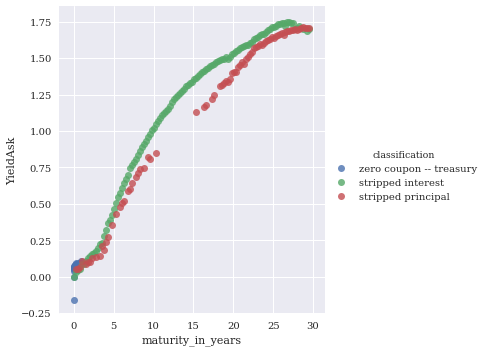

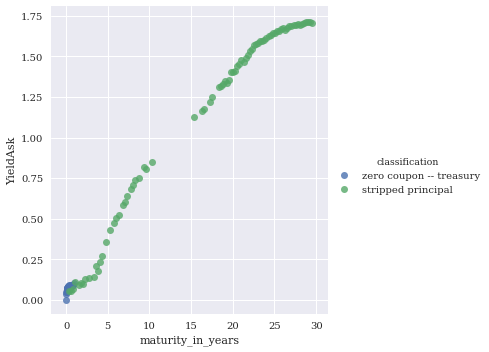

In [43]:
zero_ind = (np.logical_or(treasury_bond_df.classification.str.startswith("zero"), treasury_bond_df.classification.str.startswith("stripp")))
zeros_df = treasury_bond_df[zero_ind].copy()
tb_df_grouping_z = zeros_df.groupby(['classification'])
print(tb_df_grouping_z['maturity_in_years'].describe()) 

# Plots
sns.lmplot(x="maturity_in_years", y="YieldAsk", data=zeros_df, fit_reg=False, hue='classification', legend=True)
print(zeros_df[zeros_df['YieldAsk'] < 0.0])
zero2_ind = np.logical_and((np.logical_or(treasury_bond_df.classification.str.startswith("zero"),
                                          treasury_bond_df.classification.str.endswith("ed principal"))),
                           treasury_bond_df.YieldAsk >= 0.0)
estimation_df = treasury_bond_df[zero2_ind].copy()
estimation_df.excluded = False
print(estimation_df.describe())
estimation_df.to_csv("./data/BondPrices_Final.csv", header=True)
sns.lmplot(x="maturity_in_years", y="YieldAsk", data=estimation_df, fit_reg=False, hue='classification', legend=True)



### Fitting Lorimier's Method 


In [44]:
print(options_lor)
try:
    fitted = cvl.curve_builder_lorimier(options_lor, alpha=1.0e4, dbg=False)
    # print(fitted.zeros.matrix)
except ValueError as v:
    print(v)
except np.linalg.LinAlgError as l:
    print(l)

{'control': {'count': 17, 'convention': '30_360', 'columns': ['maturity', 'rate', 'zero', 'type', 'origin', 'spot', 'yield', 'forward', 'loaded'], 'date_format': '%Y-%m-%d', 'split': '-', 'date_adjust': 'follow', 'date_tol': 0.12, 'append_reset': 0, 'override': 1}, 'data': {'file': './data/BondPrices_20201030.csv'}, 'filter': [{'first': {'exclude': '', 'key': 'classification', 'func': 'startswith', 'value': 'zero', 'type': 'text'}, 'second': {'exclude': '', 'key': 'classification', 'func': 'endswith', 'value': 'ed principal', 'type': 'text'}, 'operator': 'or'}, {'exclude': '', 'key': 'YieldAsk', 'func': 'GT', 'value': 0, 'type': 'numeric'}, {'exclude': 'excluded', 'key': 'maturity_in_years', 'name': 'Price', 'value': 2, 'type': 'repeated_maturity'}], 'review': {'comparisons': {'yield': {'comp': 'yield_hat', 'name': 'yield_diff'}}, 'plots': {'actual_v_proj': {'comparison': {'series': 'yield', 'points': 85}}}}, 'start_date': '2020-10-30'}


yield yield_diff
        yield_hat  yield_diff
count  121.000000  121.000000
mean     0.776921   -0.000296
std      0.683588    0.002808
min      0.062975   -0.018565
5%       0.071956   -0.003818
25%      0.093504   -0.000747
50%      0.600067   -0.000069
75%      1.535907    0.000675
95%      1.701635    0.003162
max      1.714439    0.007862


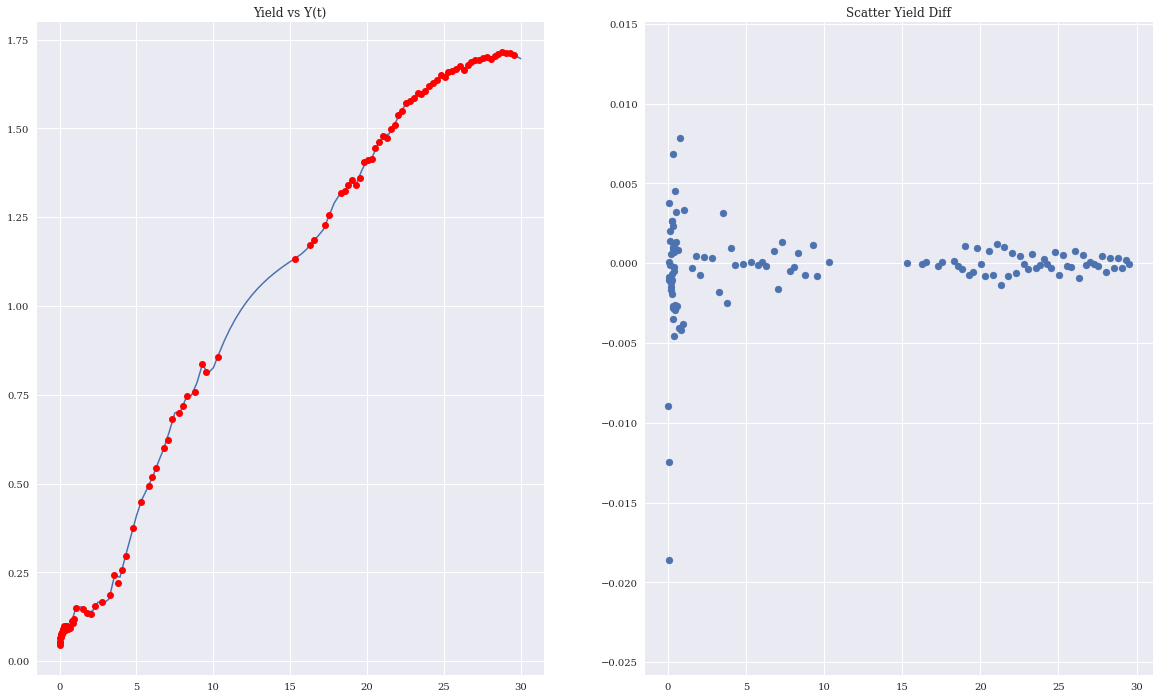

In [45]:
rvw = int_disc_rvw.discount_calculator_review(options_lor['review'], fitted.zeros, dbg=True)
rvw.review()
rvw.plot_act_projected('yield', title=['Yield vs Y(t)','Scatter Yield Diff'])

## Prices
### Prices (zeros)

         maturity       Price        zero   type  origin   spot       yield     forward  loaded   date_diff   CalcPrice  Price_Diff  yield_error
count  121.000000  121.000000  121.000000  121.0   121.0  121.0  121.000000  121.000000   121.0  121.000000  121.000000  121.000000   121.000000
mean    11.070983   86.645037    0.866450    8.0     1.0    0.0    0.776921    1.211597     1.0    0.244169   86.645025   -0.000012    -0.000296
std     10.929915   15.077056    0.150770    0.0     0.0    0.0    0.683588    1.164601     0.0    0.472907   15.077031    0.006309     0.002808
min      0.027778   60.396000    0.603950    8.0     1.0    0.0    0.062975   -0.030470     1.0    0.002778   60.394987   -0.021136    -0.018565
5%       0.091667   62.148500    0.621393    8.0     1.0    0.0    0.071956    0.076813     1.0    0.005556   62.139338   -0.011026    -0.003818
25%      0.397222   71.270500    0.712811    8.0     1.0    0.0    0.093504    0.102168     1.0    0.019444   71.281058   -0.00199

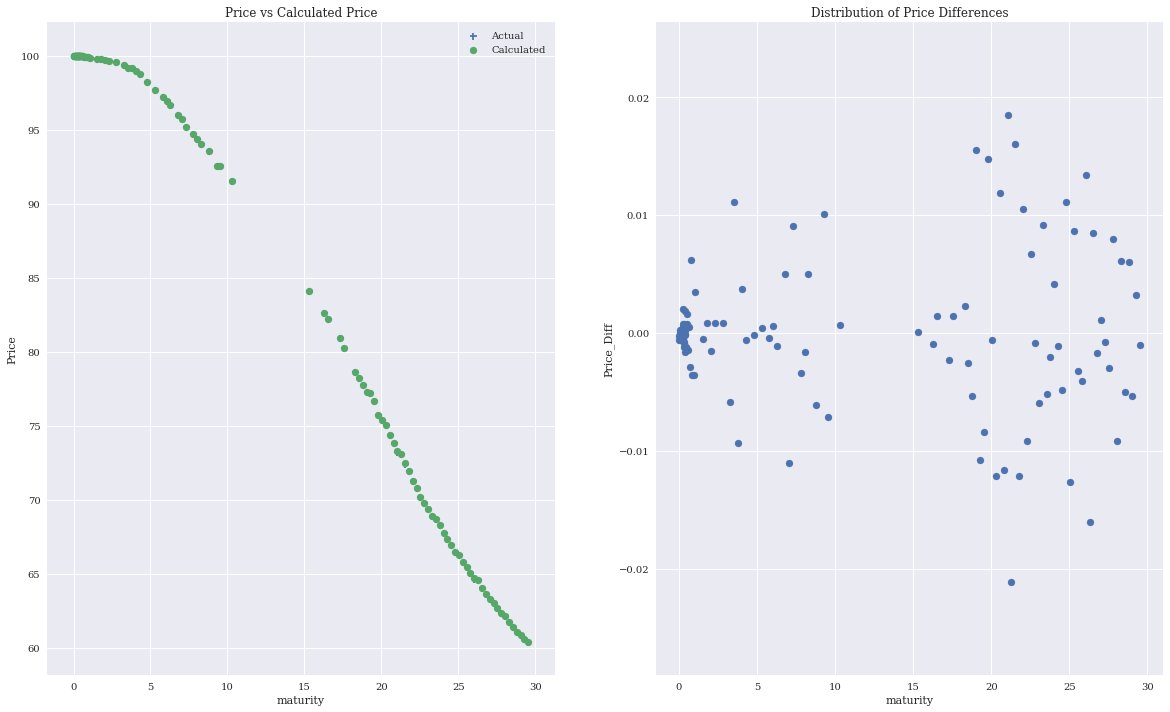

In [46]:
# res_zeros = fitted.results.copy()
res_zeros = fitted.results.rename(columns={'rate': 'Price'})
res_zeros['CalcPrice'] = 100.*res_zeros['zero']
res_zeros['Price_Diff'] = res_zeros['CalcPrice'] - res_zeros['Price']
if isinstance(rvw, int_disc_rvw.discount_calculator_review):
    res_zeros['yield_error'] = np.zeros(res_zeros.shape[0])
    
    for row in res_zeros.iterrows():
        res_zeros.loc[row[0], 'yield_error'] = rvw.results.loc[fitted.instruments[row[0]].maturity]['yield_diff']
        
        
print(res_zeros.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

if dbg:
    
    res_zeros['Price_Diff_Ind'] = (np.abs(res_zeros['Price_Diff']) > 0.0175)
    print(res_zeros[res_zeros.Price_Diff_Ind])
    if 'yield_error' in res_zeros.columns:
        x1_bg = res_zeros.groupby(['Price_Diff_Ind'])
        print(x1_bg[['maturity', 'Price', 'CalcPrice', 'yield','Price_Diff', 'yield_error']].describe())
        print(res_zeros['Price_Diff'].corr(res_zeros['yield_error']), 
              res_zeros['Price_Diff'].corr(np.exp(res_zeros['yield_error'])))

comp_plot(res_zeros, 'Price', "CalcPrice", maturity='maturity', title=["Price vs Calculated Price", "Distribution of Price Differences"]) 

### Prices (Notes & Bonds)

In [47]:
res = { "PriceBid": [], "YieldBid": [], "Spread": [], "PriceAsk": [], "YieldAsk": [], "Price": [],
        "CalcPrice": [], "maturity": [], "Price_Diff": [],"Price_Diff2": [], "Price_Diff_Perc": [], "CalcPrice_YA":[],
        "CalcPrice_YB":[], "CalcYield": [], "WAM": [], "Coupon": [], "SpreadPerc": [], "AccruedInterest": [],
        "PriceDirty":[]
       }
ndx = []
opt3 = copy.deepcopy(options_lor)
opt3['control']['date_format'] = '%m/%d/%Y'
opt3['start_date'] = '10/30/2020'

for row in treasury_bond_df.iterrows():
    # if not row[1]['excluded']:
    if not row[1]['excluded'] and not (row[1]['classification'].find("(ser)") >= 0):
        ndx.append(row[0])
        res['PriceBid'].append(row[1]['PriceBid'])
        res['YieldBid'].append(row[1]['YieldBid'])
        res['PriceAsk'].append(row[1]['PriceAsk'])
        res['YieldAsk'].append(row[1]['YieldAsk'])
        res['Spread'].append(row[1]['Spread'])
        res["SpreadPerc"].append(100*row[1]['Spread']/row[1]['PriceBid'])
        
        
        x1 = row[1]['Price']
        res['Price'].append(x1)
        res["maturity"].append(row[1]["maturity_in_years"])
        res["Coupon"].append(row[1]['Coupon'])
        
        daycount = row[1]['daycount'].replace("/", "_").lower()
        cpn = int_rate.intbase.fixed_coupon(row[1]['Coupon'], 'SEMI', daycount)
        opt3['control']['convention'] = daycount
        fxd = int_rate.fixed_coupon_bond(row[0], first=opt3['start_date'],
                                         maturity=row[1]['maturity_date'], options=opt3,
                                         princ=100., coupon=cpn, price=row[1]['Price'])
        
        res['WAM'].append(fxd.calc_WAM())
        res["CalcPrice_YA"].append(fxd.calc_price_yields(row[1]['YieldAsk']))
        res["CalcPrice_YB"].append(fxd.calc_price_yields(row[1]['YieldBid']))
        res["CalcYield"].append(fxd.calc_yield(row[1]['Price']))
        
        x2 = fxd.calc_price_zeros(fitted.zeros)
        res['CalcPrice'].append(x2)
        res['Price_Diff'].append(x2 - x1)
        res['Price_Diff_Perc'].append(100.*(x2 -x1)/x1)
        x3 = fxd.calc_accrued_interest(coupon_date=fxd.cash_flow_df.index[1])
        res['AccruedInterest'].append(x3)
        x1 = x1 + x3
        res['PriceDirty'].append(x1)
        res['Price_Diff2'].append(x2 - x1)

res_fnl = pd.DataFrame(res, index=ndx)
# res_fnl.to_csv("./data/errant_cf_prices.csv",header=True)
# print(fxd.get_price(),"\n", fxd.cash_flow_df[-1:], "\n", fxd.cash_flow_df[:1])    
print(res_fnl.describe())    

         PriceBid    YieldBid      Spread    PriceAsk    YieldAsk       Price   CalcPrice    maturity  Price_Diff  Price_Diff2  Price_Diff_Perc  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   149.000000       149.000000   
mean   113.575919    0.474141    0.113483  113.689403    0.443161  113.632661  113.935496    6.155909    0.302835    -0.345108         0.221245   
std     18.253973    0.508513    0.127023   18.369092    0.519341   18.311513   18.729657    8.076096    0.504409     0.746656         0.355165   
min     98.209000    0.078000    0.001000   98.259000   -0.160000   98.234000   98.436435    0.011111   -0.014522    -3.594537        -0.014329   
25%     99.985000    0.105000    0.008000   99.987000    0.080000   99.986000   99.984683    0.366667   -0.000433    -0.640944        -0.000433   
50%    103.025000    0.177000    0.047000  103.072000    0.142000  103.048500  103.097365    1.958904    0.046721    -

97 0.651 31 1.0


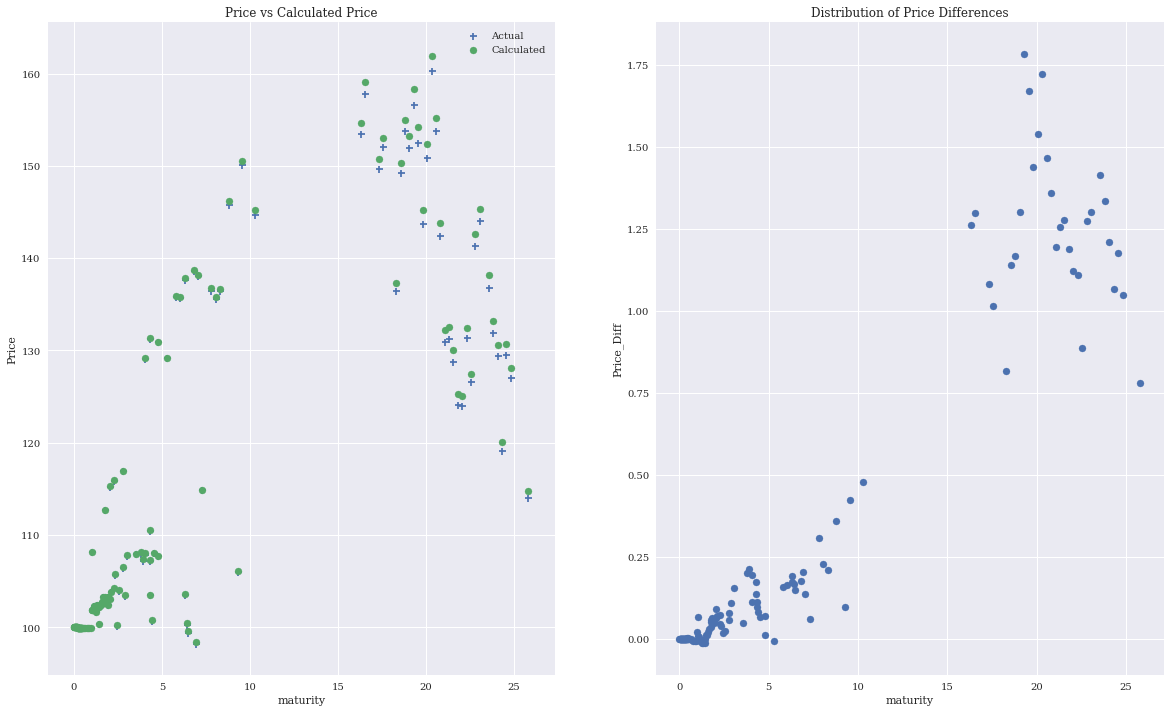

In [48]:
comp_plot(res_fnl, 'Price', "CalcPrice", maturity='maturity', diff='Price_Diff', title=["Price vs Calculated Price", "Distribution of Price Differences"])
cnt_gt = np.sum(res_fnl['CalcPrice'] > res_fnl['Price'])
mat = 7.5
mat_ind = np.logical_and(res_fnl.maturity >= mat, abs(res_fnl.Price_Diff_Perc) > .50)
cnt_gt_mat10 = np.sum(mat_ind)
print(cnt_gt, round(cnt_gt / res_fnl.shape[0], 3), cnt_gt_mat10, round(cnt_gt_mat10/ res_fnl[res_fnl.maturity >= mat].shape[0]))

## Process Review
1. Analyze
2. Exclusions
3. Fit
4. Model Review
    - How well do you recover your data?

## Next Steps
* Better Bond Pricing Data
* Esttimation of Additional Rates
    - FHLMC 30 year
    - Constant Maturity Rates
* Simulation
    - Option (HJM ... )
        - Vasicek
        - LFM
        - LMM
        * __Additional Data__:
            - Options Data (Volatility)
            - LIBOR data
* Analytic metrics
    - Discounting
    - Z-spread 
    - Option Adjusted Spread (OAS)
    - Option Cost
    - Effective Duration & Convexity

## Closing Remarks
* Why Does it matter?
    - Embedded Options
    - Complex Structures
    - Common Duration metrics assume constant CF in face of changing interest rates
   
* Notes Regarding the Bibliography
    - Data & Analytics Providers 
        QuantLib (C++ & Python)
    - Open Source 
* Contact
    - __email__: slpenn13@hottmail.com
    - __github handle__: slpenn13

# Bibliography
## Data & Analytics Providers
* [FRED ( St.Louis Federal Reserve Data Site )](https://fred.stlouisfed.org/)
    - DGS30
    - ICERATES1100USD30Y
* __Big Three:__ 
 - [Intex](https://www.intex.com/main/)
 - [Bloomberg](https://www.bloomberg.com/)
 - [YieldBook](https://www.yieldbook.com/m/home/index.shtml)

### Python
 * [Anaconda](https://pypi.org/project/businessdate/)
     - Includes pandas, matplotlib, numpy, scipy, seaborn and statsmodels
 * [BusinessDate](https://pypi.org/project/businessdate/)
 
### Open Source
 * [QuantLib](https://www.quantlib.org/)
 * [GNU Scientific Library](https://www.gnu.org/software/gsl/)
 
### C++
 * [Boost](https://www.boost.org/)
     - includes dates, random number, linear algebra and memory management libraries
 
## General Finance & Fixed Income
* Lyuu, Yuh-Duah __Financial Engineering and Computation: Principles, Mathematics, Algorithms__, Cambridge University Press, 
   Cambidge, UK, 2002
* Stefanica, Dan __A Primer for the Mathematics of Financial Engineering__, FE Press, New York, NY, 2011
* Stefanica, Dan __A Linear Algebra Primer for Financial Engineering__, FE Press, New York, NY, 2014
* Tuckman, B., Serrat, A. __Fixed Income Securities: Tools for Today's Markets, Third Edition__, John Wiley & Sons, Hoboken, NY 2012  
## Rate Modelling Specific
* Cairns, Andrew J. G. __Interest Rate Models: An Introduction__, Princeton University Press, Princeton, NJ, 2004.
* Filipovic, Damir __Term Structure Models__, Springer Press, New York, NY 2009.
* [Interest Rate Models](https://www.coursera.org/learn/interest-rate-models)
    - Dr. Filipovic's coursera class on interest rate modelling
## Structured Securities
* Schultz, Glenn __Investing in Mortgage-Backed and Asset-Backed Securities__, John Wiley & Sons, Hoboken, NJ, 2016
## Tooling
* Joshi, Mark __C++ Design Patterns and Derivatives Pricing__, Cambridge University Press, Cambridge, UK, 2004 
* [Data Tools](https://github.com/slpenn13/pythondatatools)
    - My Github repository containing tooling specific to data extraction (e.g. FRED) and storing data to databases
* [PythonInterestRates](https://github.com/slpenn13/pythoninterestrates)
    - My Github repository containing tools specific to fitting, analysis and application of interest rate models
* Ruppert, David __Statistics and Data Analysis for Financial Engineering__, Springer, New York, NY, 2010.
* [Speaking](https://github.com/slpenn13/Speaking/tree/main/fsu202011)
    - My Directory in Github repository including this talk
    

## Exploring Differences

         PriceBid    YieldBid      Spread    PriceAsk    YieldAsk       Price   CalcPrice    maturity  Price_Diff  Price_Diff2  Price_Diff_Perc  \
count  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000  149.000000   149.000000       149.000000   
mean   113.575919    0.474141    0.113483  113.689403    0.443161  113.632661  113.935496    6.155909    0.302835    -0.345108         0.221245   
std     18.253973    0.508513    0.127023   18.369092    0.519341   18.311513   18.729657    8.076096    0.504409     0.746656         0.355165   
min     98.209000    0.078000    0.001000   98.259000   -0.160000   98.234000   98.436435    0.011111   -0.014522    -3.594537        -0.014329   
25%     99.985000    0.105000    0.008000   99.987000    0.080000   99.986000   99.984683    0.366667   -0.000433    -0.640944        -0.000433   
50%    103.025000    0.177000    0.047000  103.072000    0.142000  103.048500  103.097365    1.958904    0.046721    -

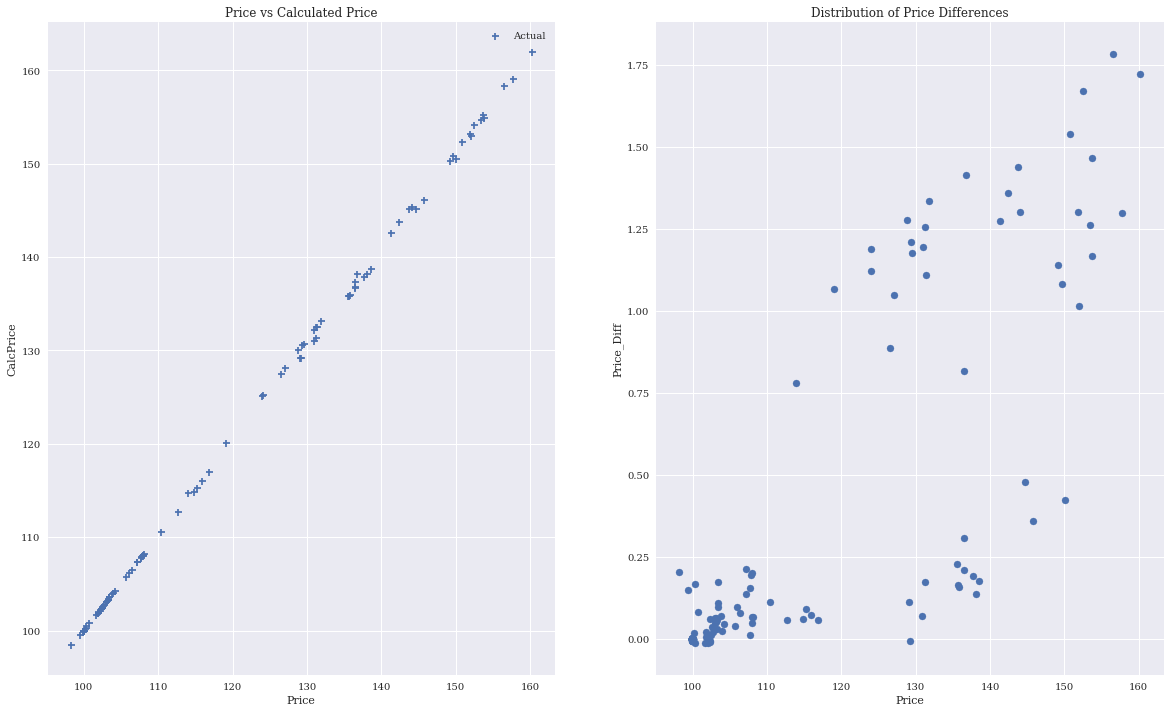

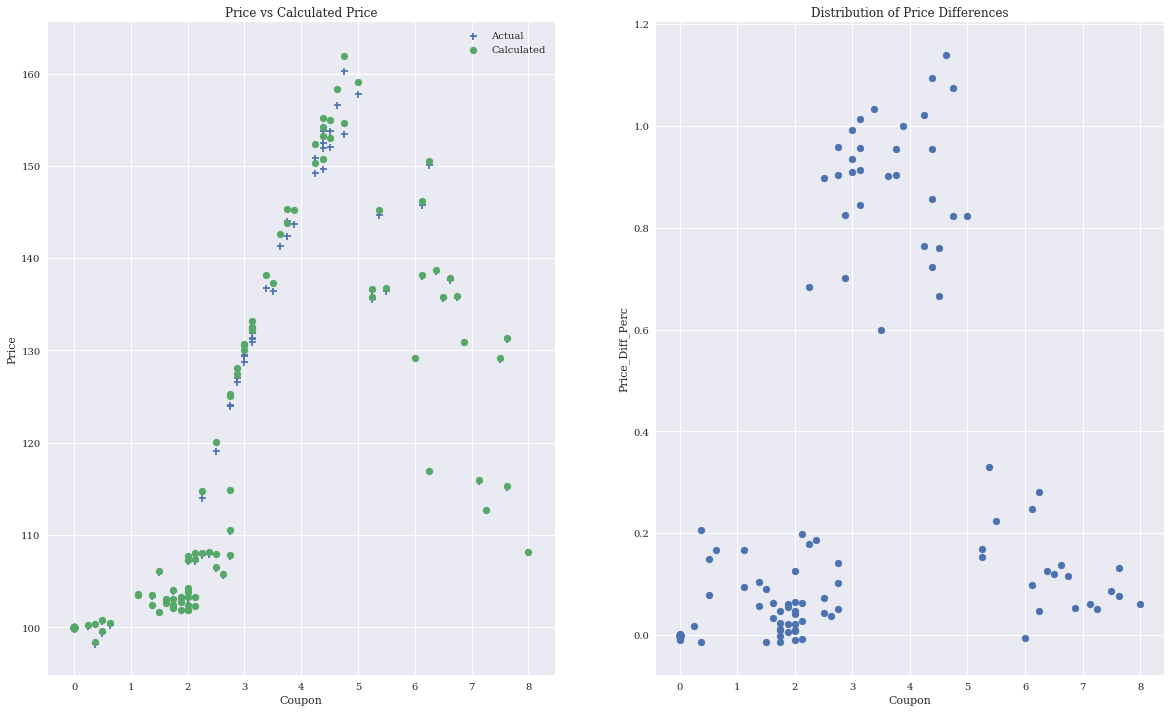

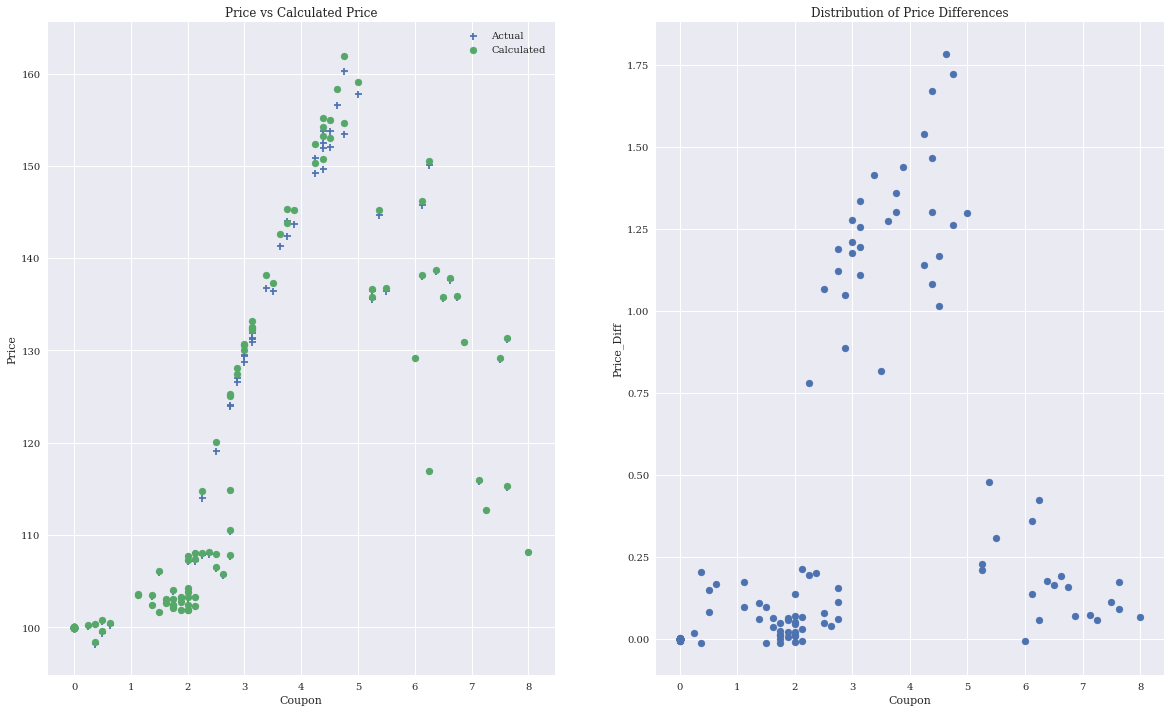

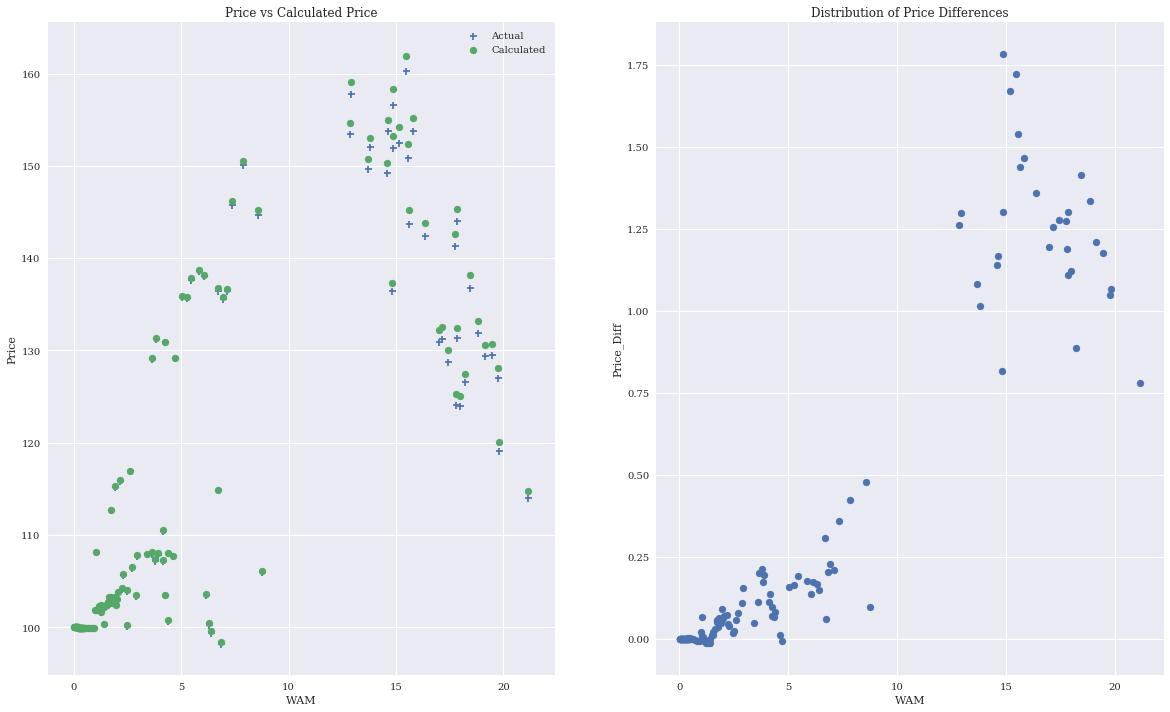

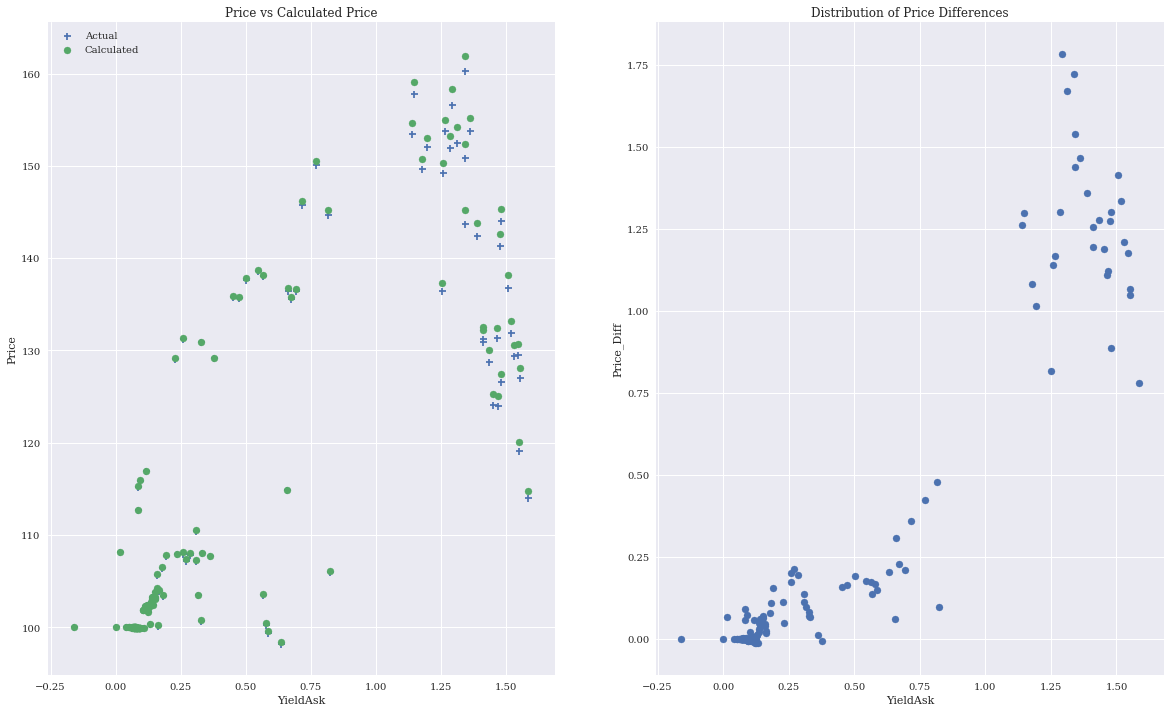

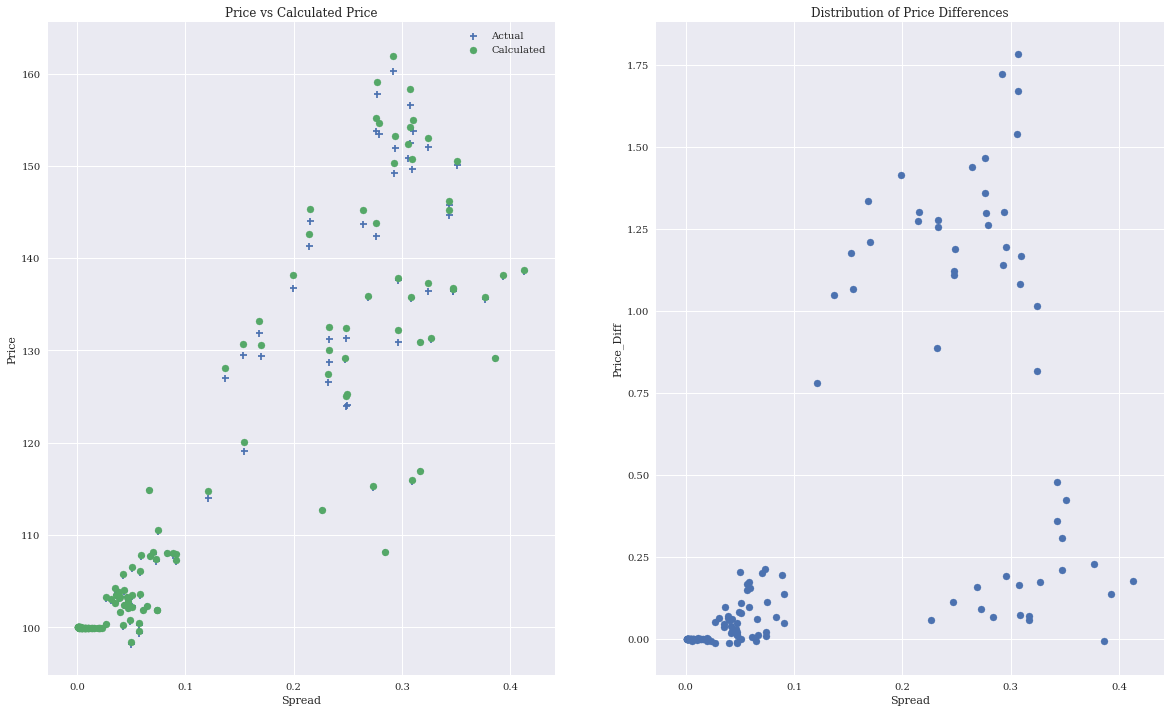

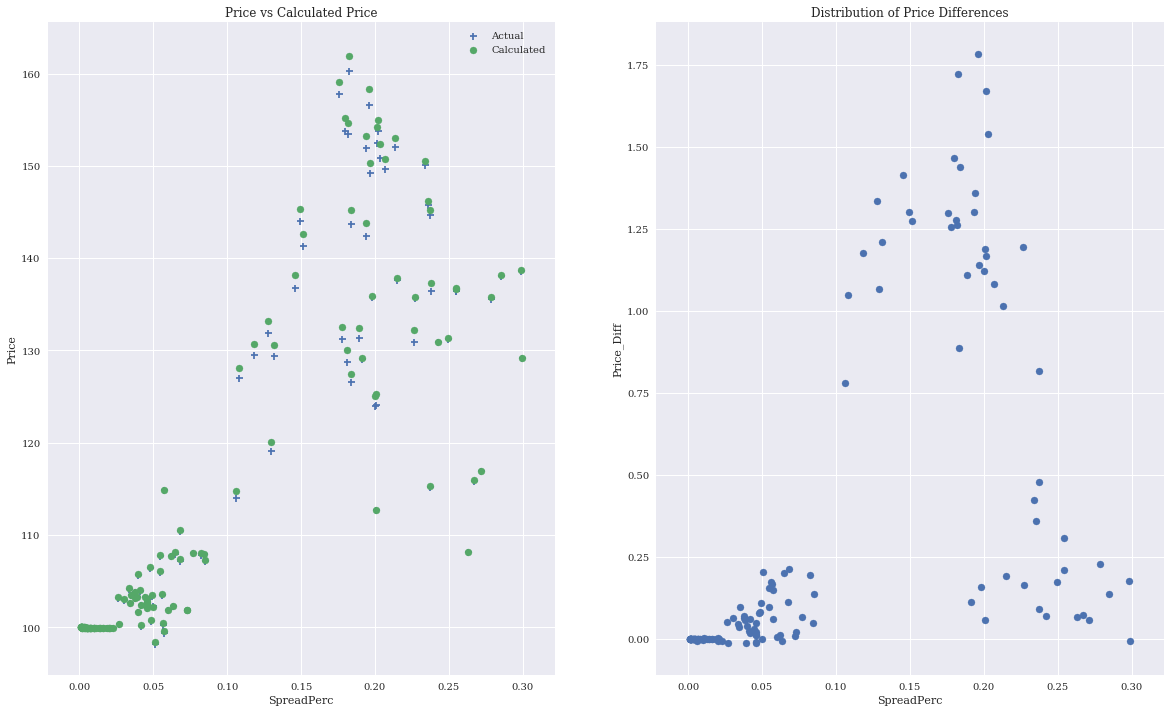

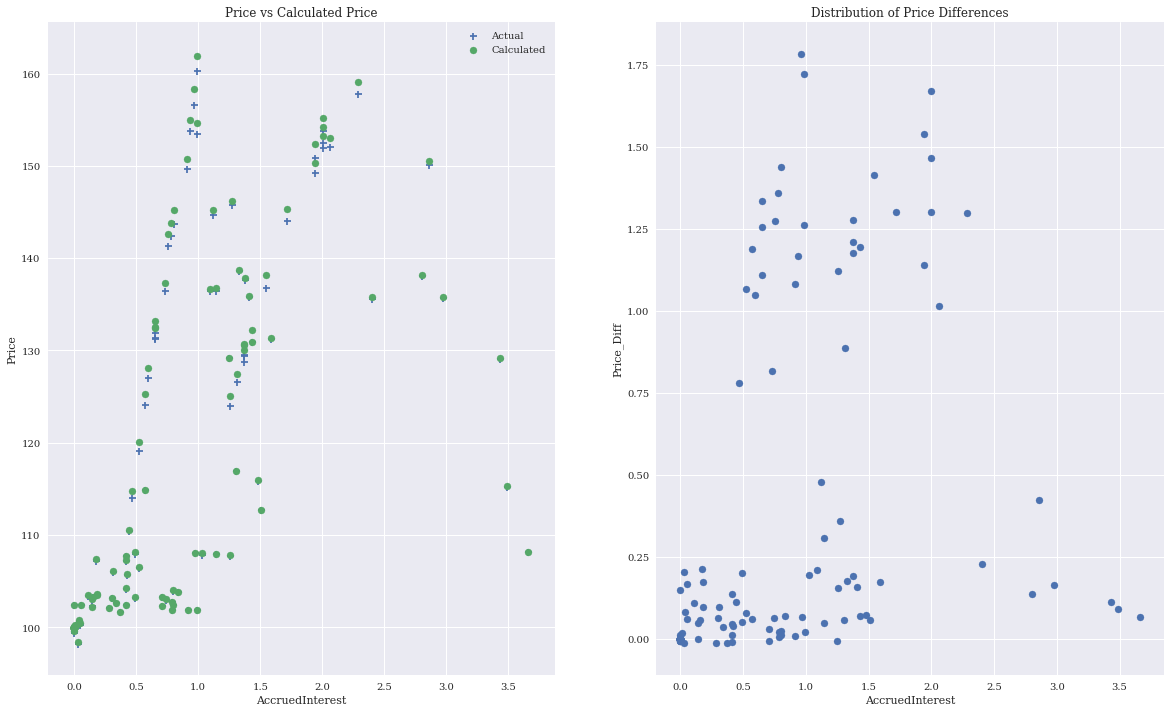

In [18]:
dbg=True
if dbg:
    print(res_fnl.describe())
    print(res_fnl[mat_ind].sort_values(by=['Coupon']))
    print(res_fnl[mat_ind].describe())
    print(treasury_bond_df.loc[res_fnl[mat_ind].index].sort_values(by=['Coupon']))
    print(res_fnl.loc["912810RK6"])
    
strt = int_date.convert_date_bdte(opt3['start_date'], opt3)
cur1 = int_date.convert_date_bdte('02/15/2021', opt3)
cur2 = int_date.convert_date_bdte('02/15/2045', opt3)

cur = int_date.convert_date_bdte(treasury_bond_df.loc['912810RK6', 'maturity_date'], opt3)
x1 = np.zeros(6)
x1[0] = strt.get_year_fraction(cur, '30360')
x1[1] = strt.get_year_fraction(cur, 'act_365')
x1[2] = strt.get_year_fraction(cur1, '30360')
x1[3] = strt.get_year_fraction(cur1, 'act_365')
x1[4] = strt.get_year_fraction(cur2, '30360')
x1[5] = strt.get_year_fraction(cur2, 'act_365')

print((x1[1] - x1[0]), x1)
comp_plot(res_fnl, 'CalcPrice', 'Price', maturity='Price', title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, 'Price', 'CalcPrice', maturity='Coupon', diff="Price_Diff_Perc",
          title=["Price vs Calculated Price", "Distribution of Price Differences"])

price="Price"
diff_chc = "Price_Diff"
comp_plot(res_fnl, price, 'CalcPrice', maturity='Coupon', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, price, 'CalcPrice', maturity='WAM', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, price, 'CalcPrice', maturity='YieldAsk', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, price, 'CalcPrice', maturity='Spread', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, price, 'CalcPrice', maturity='SpreadPerc', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])
comp_plot(res_fnl, price, 'CalcPrice', maturity='AccruedInterest', diff=diff_chc, title=["Price vs Calculated Price", "Distribution of Price Differences"])

